## Import

In [1]:
import pandas as pd
import requests
from urllib.request import urlopen
import json
from pandas import json_normalize
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 삼성전자의 장부 정보를 불러온다.
key = '3510098a70675da8c7a834ab9a8df850762900a0'
code = '00126380'
years = [2019, 2020, 2021, 2022, 2023]
report_codes = [11013, 11012, 11014, 11011]

urls = [f"https://opendart.fss.or.kr/api/fnlttSinglAcnt.json?crtfc_key={key}&corp_code={code}&bsns_year={y}&reprt_code={r}" 
        for y in years for r in report_codes if (y,r) not in [(2023,11014), (2023,11011)]]

In [3]:
samsung_capital = pd.DataFrame()
samsung_profit = pd.DataFrame()
samsung_sale = pd.DataFrame()

for url in urls: 
    res = requests.get(url)
    data = json.loads(res.text)
    # 자본총계
    samsung_capital = pd.concat([samsung_capital, 
                                json_normalize(data['list']).query('account_nm == "자본총계" and fs_div=="CFS"')\
                                 [['reprt_code','bsns_year','corp_code', 'stock_code', 'account_nm', 'thstrm_amount']]])
    # 당기순이익
    samsung_profit = pd.concat([samsung_profit, 
                                json_normalize(data['list']).query('account_nm == "당기순이익" and fs_div=="CFS"')\
                                 [['reprt_code','bsns_year','corp_code', 'stock_code', 'account_nm', 'thstrm_amount']]])  
    # 매출액
    samsung_sale = pd.concat([samsung_sale, 
                             json_normalize(data['list']).query('account_nm == "매출액" and fs_div=="CFS"')\
                                 [['reprt_code','bsns_year','corp_code', 'stock_code', 'account_nm', 'thstrm_amount']]])  
print('자본총계:', samsung_capital.shape)
print('당기순이익:', samsung_profit.shape)
print('매출액:', samsung_sale.shape)

자본총계: (18, 6)
당기순이익: (18, 6)
매출액: (18, 6)


In [4]:
# 자본총계 데이터 전처리를 수행한다.
samsung_capital['monday'] = samsung_capital['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
samsung_capital['date'] = pd.to_datetime(samsung_capital['bsns_year']+samsung_capital['monday'], format='%Y%m%d', errors='coerce')
samsung_capital.drop(['monday'], axis=1, inplace=True)
samsung_capital['capital'] = samsung_capital['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000
samsung_capital = samsung_capital.set_index('date')
samsung_capital.shape

(18, 7)

In [5]:
# 당기순이익 데이터 전처리를 수행한다.
samsung_profit['monday'] = samsung_profit['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
samsung_profit['date'] = pd.to_datetime(samsung_profit['bsns_year']+samsung_profit['monday'], format='%Y%m%d', errors='coerce')
samsung_profit.drop(['monday'], axis=1, inplace=True)
samsung_profit['thstrm_amount'] = samsung_profit['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000

# 마지막 분기의 당기순이익은 연합산으로 해당 분기값은 별도로 구한다.
ease = samsung_profit.groupby('bsns_year')[['thstrm_amount']].agg(lambda x: 2*max(x)-sum(x)).reset_index()
ease['reprt_code'] = '11011'
ease = samsung_profit.drop(['thstrm_amount'], axis=1).merge(ease, on=['bsns_year','reprt_code'])
samsung_profit = pd.concat([samsung_profit.query("reprt_code!='11011'"), ease]).reset_index(drop=True).set_index('date')
samsung_profit.shape

(18, 6)

In [6]:
# 매출액 데이터 전처리를 수행한다.
samsung_sale['monday'] = samsung_sale['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
samsung_sale['date'] = pd.to_datetime(samsung_sale['bsns_year']+samsung_sale['monday'], format='%Y%m%d', errors='coerce')
samsung_sale.drop(['monday'], axis=1, inplace=True)
samsung_sale['thstrm_amount'] = samsung_sale['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000

# 마지막 분기의 매출액은 연합산으로 해당 분기값은 별도로 구한다.
ease = samsung_sale.groupby('bsns_year')[['thstrm_amount']].agg(lambda x: 2*max(x)-sum(x)).reset_index()
ease['reprt_code'] = '11011'
ease = samsung_sale.drop(['thstrm_amount'], axis=1).merge(ease, on=['bsns_year','reprt_code'])
samsung_sale = pd.concat([samsung_sale.query("reprt_code!='11011'"), ease]).reset_index(drop=True).set_index('date')
samsung_sale.shape

(18, 6)

In [7]:
# 삼성전자의 주식시세를 불러온다.
# 해당 API는 2020년 1월 2일 데이터부터 제공받을 수 있다.
key = "frp9m%2F2tsrmX8ySEWKRQPABZ0%2FhuA3tmcG53xJLo0n%2B3TgURv1aRXGOcqrxHdXW9SDc30IkK5hWiy6QcfpqIcg%3D%3D"
code = '005930'
nrows = 10000
start, end = '20200101' , '20231018'

In [8]:
url = f'https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={key}&likeSrtnCd={code}&numOfRows={nrows}&beginBasDt={start}&endBasDt={end}'
result = urlopen(url) 
samsung_stock = BeautifulSoup(result, 'lxml-xml')
samsung_stock = pd.DataFrame([i.text.split('\n')[1:-1] for i in samsung_stock.find_all("item")], 
                              columns= ["date", "stockCode", "_", "stockName", "market", "close", "_", "_", 
                                        "open", "high", "low", "volume", "amount", "totShare", "totAmount"])
samsung_stock = samsung_stock[[i for i in samsung_stock.columns if i != "_"]]
samsung_stock['date'] = pd.to_datetime(samsung_stock['date'], format='%Y%m%d')
samsung_stock['close'] = samsung_stock['close'].astype('f')
samsung_stock.shape

(936, 12)

In [9]:
# API 키, 지수코드, 질의 시작날짜, 질의 종료날짜, 데이터 기간단위, 계정항목코드에 만족하는 데이터 반환 함수를 정의한다.
def Kbank(KEY, SCODE, START, END, FREQ, ICODE):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{KEY}/json/kr/1/10000/{SCODE}/{FREQ}/{START}/{END}/{ICODE}"
    r = requests.get(url)
    ecos = json.loads(r.text)
    ecos = pd.json_normalize(ecos['StatisticSearch']['row'])
    # 시계열 데이터로 변경
    ecos['TIME'] = pd.to_datetime(ecos['TIME'], format='%Y%m%d')
    ecos.set_index('TIME', inplace=True)
    # 불필요한 데이터 제거
    ecos.drop(ecos.columns[ecos.notna().sum() <= 10], axis=1, inplace=True)
    return ecos['DATA_VALUE'].astype('f').rename('interest')

In [10]:
# 주주요구수익률로 회사채(3년 BBB-)를 불러온다.
key = "EMW57AXXGM4F3IZN9A21"
statcode = '817Y002' # 시장금리
freq, start, end = 'D', '20200101', '20231018'
itemcode = '010320000'

fnb = Kbank(key, statcode, start, end, freq, itemcode)
display(fnb.head())

TIME
2020-01-02    8.021
2020-01-03    7.978
2020-01-06    7.981
2020-01-07    8.032
2020-01-08    8.055
Name: interest, dtype: float32

## 상대가치 평가
투자를 위해선 주식의 가치를 알아야 한다. 과거 기업정보를 기반으로 `미래지향`적인 가치인 주가를 상대적으로 평가할 수 있다.<br>
유사 분야, 종목의 주식 대비 해당 주식의 가치비율 등의 비교는 가능하나 지표의 `절대적인 값`으로 가치를 판단할 수 없다.

### PBR(주가순자산비율)
  장부상 가치가 큰 기업을 가치있는 기업으로 생각하는 경우 사용하는 평가지표이다.
  $$ PBR = \frac{\text{주가}}{\text{주당 장부가격}} = 1 + \frac{\text{성장성의 현재가치}}{\text{주당 장부가격}} = \frac{\text{시가총액}}{\text{자기자본}} = \frac{\text{주가}}{BPS}$$
  $\bullet$ PBR이 크면 현재 장부가치에 비해 성장성이 큰 주식으로 성장주라 한다.<br>
  $\bullet$ 반대로 PBR이 작으면 현재의 자산이 기업가치에 큰 부분을 차지하는 주식으로 비즈니스 모델이 안정적인 주식으로 가치주라 한다.<br>
  $\bullet$ 일반적으로 가치주 수익률이 성장주 수익률보다 높다. 가치주는 더 많은 위험을 부담한다는 것인데 CAPM은 이를 설명할 수 없다.<br>
  $~~$ 성장주의 회사 운영에 금리가 큰 영향력을 행사해 일어난 이상현상이다.<br>
  $\bullet$ PBR이 1보다 크면 위험프리미엄이 있는 상태, 작다면 자본대비 저평가된 주식을 의미한다.<br>
  $\bullet$ 낮은 PBR을 갖는 주삭 중 일부는 과소평가되어 투자대상으로 삼기 적절하나 일부는 정말 가치가 낮은 주식이다.
### PER(주가수익비율)
  이익을 많이 내는 기업을 가치있는 기업으로 생각하는 경우 사용하는 평가지표이다.
  $$PER = \frac{\text{주가}}{\text{주당순이익}} = \frac{\text{시가총액}}{\text{당기순이익}}, \text{투자수익률} = \frac{100}{PER}$$
  $\bullet$ 주당순이익이 주가에 도달하기 위해 걸리는 시간과 동일하다.<br>
  $\bullet$ PER이 작으면 저평가, 높으면 고평가된 주식이라고 한다.<br>
  $\bullet$ 연이익 변동이 큰 회사에는 적용하기 부적절한 지표이다.

### ※ ROE(자기자본이익률)
PBR과 PER 관계는 ROE(자기자본이익률, 투자금액이 이익으로 전환된 정도)로 표현할 수 있다.
  $$PBR = ROE \times PER, ~ROE = \frac{\text{순이익}}{\text{자본}}$$
  $\bullet$ ROE는 순이익률, 자산회전율, 재무레버리지로 구성할 수 있다.<br>
  $\bullet$ 부채 증가, 배당$\cdot$성과급 등의 자본 축소로 ROE를 높일 수 있다.
  $$ROE = \frac{\text{순이익}}{\text{자본}} =  \frac{\text{순이익}}{\text{매출액}} \times  \frac{\text{매출액}}{\text{자산}} \times  \frac{\text{자산}}{\text{자본}} = \text{순이익률} \times \text{자산회전률} \times \text{재무레버리지}$$

In [11]:
# 1. ROE를 산출한다.
samsung_profit['profit'] = samsung_profit.thstrm_amount.rolling(4).sum()
samsung_roe = samsung_profit['profit'] / samsung_capital['capital']
samsung_roe

date
2019-03-31         NaN
2019-06-30         NaN
2019-09-30         NaN
2019-12-31    0.068147
2020-03-31    0.080322
2020-06-30    0.081199
2020-09-30    0.094476
2020-12-31    0.054838
2021-03-31    0.098234
2021-06-30    0.112254
2021-09-30    0.129497
2021-12-31    0.080012
2022-03-31    0.128117
2022-06-30    0.135256
2022-09-30    0.127878
2022-12-31    0.131117
2023-03-31    0.092794
2023-06-30    0.066261
Freq: Q-DEC, dtype: float64

In [12]:
# 2. 1,2,3분기 재무제표는 분기말 30일후, 4분기 재무제표는 60일후에 정보를 입수한다고 가정한다.
#    가정이 필요한 이유는 미래가치를 반영해 기업의 미래 성장성을 파악하고자 함이며 반영기간을 설정한 것이다.
samsung = pd.concat([samsung_profit['profit'], samsung_capital['capital'], samsung_roe.rename('roe')], axis=1).dropna().reset_index()
samsung['OFSdate'] = samsung['date'] + pd.Timedelta(days=45) * samsung['date'].dt.month.isin([3, 6, 9]) \
                     + pd.Timedelta(days=90) * (samsung['date'].dt.month == 12)

In [13]:
# 3. 주식데이터와 병합한다.
#   추후 절대평가에 사용하기 위해 병합 DataFrame의 변수명을 samsung_total로 한다.
samsung_total = pd.merge(samsung.drop('date', axis=1), samsung_stock, left_on='OFSdate', right_on='date', how='outer')
samsung_total = samsung_total.set_index('date').sort_index()
samsung_total

,profit,capital,roe,OFSdate,stockCode,stockName,market,close,open,high,low,volume,amount,totShare,totAmount
date,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55200.0,55500,56000,55000,12993228,719663194492,5969782550,329531996760000
2020-01-03,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55500.0,56000,56600,54900,15422255,860206709400,5969782550,331322931525000
2020-01-06,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55500.0,54900,55600,54600,10278951,567461518576,5969782550,331322931525000
2020-01-07,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55800.0,55700,56400,55600,10009778,560226659600,5969782550,333113866290000
2020-01-08,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,56800.0,56200,57400,55900,23501171,1330939275000,5969782550,339083648840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,26.942387,274.268591,0.098234,2021-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,31.691947,282.324266,0.112254,2021-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,38.430195,296.766118,0.129497,2021-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# capital, profit 모두 미래시점에도 유지된다 가정하고 결측치를 채운다.
samsung_total['capital'] = samsung_total['capital'].fillna(method='ffill')
samsung_total['profit'] = samsung_total['profit'].fillna(method='ffill')
samsung_total

,profit,capital,roe,OFSdate,stockCode,stockName,market,close,open,high,low,volume,amount,totShare,totAmount
date,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55200.0,55500,56000,55000,12993228,719663194492,5969782550,329531996760000
2020-01-03,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55500.0,56000,56600,54900,15422255,860206709400,5969782550,331322931525000
2020-01-06,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55500.0,54900,55600,54600,10278951,567461518576,5969782550,331322931525000
2020-01-07,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,55800.0,55700,56400,55600,10009778,560226659600,5969782550,333113866290000
2020-01-08,NaN,NaN,NaN,NaT,005930,삼성전자,KOSPI,56800.0,56200,57400,55900,23501171,1330939275000,5969782550,339083648840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,26.942387,274.268591,0.098234,2021-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,31.691947,282.324266,0.112254,2021-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,38.430195,296.766118,0.129497,2021-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# 4. 자본으로 구하는 PBR, 이익으로 구하는 PER을 산출한다.
samsung_total['PBR'] = samsung_total['totAmount'].astype('f')/(samsung_total['capital']*1000000000000)
samsung_total['PER'] = samsung_total['totAmount'].astype('f')/(samsung_total['profit']*1000000000000)

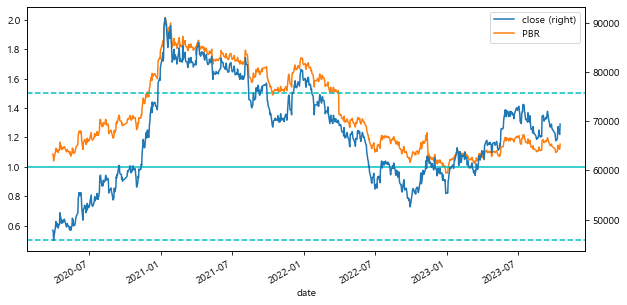

In [16]:
ax = samsung_total[['close', 'PBR']].dropna().plot(secondary_y=['close'], figsize=(10,5))
ax.axhline(1.5, c='c', ls='--')
ax.axhline(1.0, c='c')
ax.axhline(.5, c='c', ls='--')
plt.show()

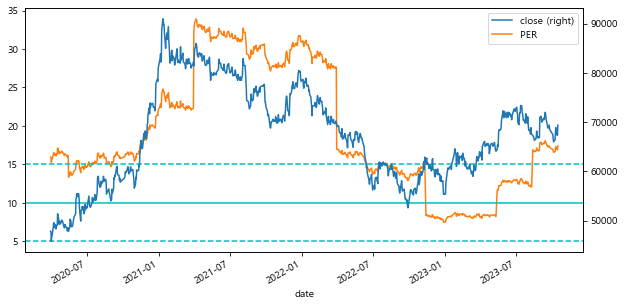

In [17]:
ax = samsung_total[['close', 'PER']].dropna().plot(secondary_y=['close'], figsize=(10,5))
ax.axhline(15, c='c', ls='--')
ax.axhline(10, c='c')
ax.axhline(5, c='c', ls='--')
plt.show()

### Growth(성장률)
매출 성장률, 순이익 성장률, EPS 성장률로 성장주를 판단한다. 이때 성장률의 변동성도 함께 고려해야 한다.

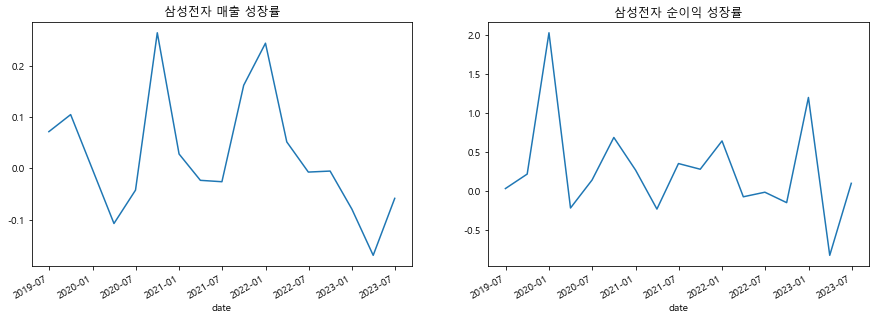

In [18]:
# 매출 성장률과 순이익 성장률을 구해본다.
fig, ax = plt.subplots(1,2,figsize=(15,5))
samsung_sale['thstrm_amount'].pct_change().plot(title="삼성전자 매출 성장률", ax=ax[0])
samsung_profit['thstrm_amount'].pct_change().plot(title="삼성전자 순이익 성장률", ax=ax[1])
plt.show()

In [19]:
# 계절적인 신제품 출시에 매출액 성장률은 변동성이 적으나 순이익 성장률의 변동성은 크다.
print('매출 성장률 변동성:', samsung_sale['thstrm_amount'].pct_change().std())
print('순이익 성장률 변동성:', samsung_profit['thstrm_amount'].pct_change().std())

매출 성장률 변동성: 0.11696213332365493
순이익 성장률 변동성: 0.637180824873714


## 절대 가치평가
유사 종목간 비교로 주식 가치를 판단하지 않고 절대적인 현금가치로  평가한다.
###  DCF(현금흐름할인법)
- 예상되는 현금흐름을 추정한 뒤 할인율로 할인해 현재가치를 구하는 방법이다.
 $$PV = \frac{\frac{C}{1+r}}{1-\frac{1}{1+r}} = \frac{C}{r}$$
 $$(C: \text{원금}, r: \text{할인율})$$

### RIM(잔여이익모델)
- 원금과 이자의 현재가치값을 합해 주식의 가치로 판단한다.
  $$\text{기업가치} = \text{자기자본(자본총계)} + \frac{\text{초과이익}}{\text{할인율}}$$
  $$\text{초과이익}= \text{순자산가치} \times (ROE - \text{주주요구수익률})$$
- 주가, 주식수, 자본총계로 투자수익률인 ROE를 추정해 주식가치를 판단할 수도 있다.
  $$ROE = \frac{\text{할인율}\times (\text{자기자본} + \text{초과이익})}{\text{자기자본}}$$
  $$\text{초과이익} = \text{주가}\times\text{주식수} - \text{자본총계}$$
- 주주요구수익률은 기업, 거시환경변화, 개인의 위험선호도에 따라 각기 다른 할인율을 적용한다.

In [20]:
# 상대가치평가때 ROE를 구한 samsung 데이터와 주주요구수익률 데이터를 병합한다.
samsung = pd.merge(fnb.reset_index(), samsung, left_on='TIME', right_on='OFSdate')
samsung = samsung.set_index('TIME').sort_index()

In [21]:
# 1. 초과이익을 구한다.
samsung['capital'] = samsung['capital'].fillna(method='ffill')
samsung['interest'] = samsung['interest']/100
samsung['excess_profit'] = samsung['capital'] * (samsung['roe']-samsung['interest'])

In [22]:
# 2. 기업가치를 구한다.
samsung['value'] = samsung['capital'] + samsung['excess_profit'] / samsung['interest']

In [23]:
# 3. 주가데이터를 병합하고 주당가치를 구한다.
samsung = pd.merge(samsung_stock, samsung.drop('date', axis=1).reset_index(), left_on='date', right_on='OFSdate', how='outer')
samsung = samsung.set_index('date').sort_index()
samsung['value'] = samsung['value'].fillna(method='ffill')

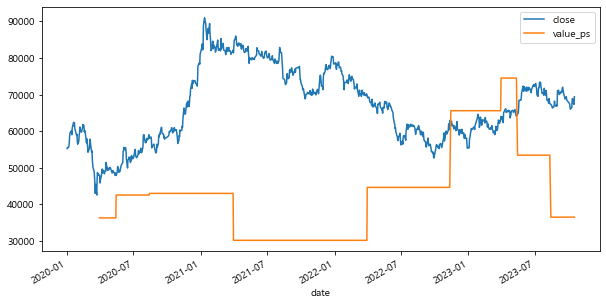

In [24]:
samsung['value_ps'] = (samsung['value']*1000000000000)/samsung['totShare'].astype('f')
samsung[['close', 'value_ps']].plot(figsize=(10,5))
plt.show()